## 1. Introduction

The Acoustic Weld Inspection Project (AKoS) addresses the challenge of ensuring the quality of weld seams in safety-critical components by introducing a novel approach utilizing machine learning, specifically autoencoders. This section provides an overview of the project's goals and the significance of leveraging acoustic data for weld seam inspection.
The Acoustic Weld Inspection Project (AKoS) aims to enhance the quality assurance process for weld seams on safety-critical components using acoustic data. In this report, we present the development of a neural network-based solution for weld seam inspection, focusing on the utilization of autoencoders for anomaly detection.The Acoustic Weld Inspection Project (AKoS) is a pioneering initiative aimed at enhancing the quality assurance process for weld seams in safety-critical components. Traditional methods often fall short in detecting subtle defects, necessitating the exploration of innovative solutions. The AKoS project leverages acoustic data to develop a robust inspection system that can identify abnormalities in weld seams with high accuracy
Weld seam quality is paramount for the structural integrity of components in various industries. Traditional inspection methods, such as visual examination and ultrasonic testing, face limitations in detecting subtle defects, especially those manifesting acoustically. The AKoS project seeks to overcome these limitations by harnessing the capabilities of machine learning, specifically autoencoders, to analyze acoustic signals associated with weld seams.

### Autoencoders in Anomaly Detection

Autoencoders are neural network architectures designed for unsupervised learning. They consist of an encoder and a decoder, which work collaboratively to learn a compressed representation of input data. In anomaly detection applications, such as the AKoS project, autoencoders excel at learning to reconstruct normal data accurately. The core principle lies in the ability to identify anomalies by detecting higher reconstruction errors when presented with abnormal data. This theoretical foundation serves as the basis for the subsequent sections detailing the implementation of autoencoders in the project.

## 2. Solution Overview

The proposed solution leverages autoencoders, a type of neural network designed for unsupervised learning. Autoencoders consist of an encoder and a decoder, with the primary objective of learning a compressed representation of input data. In the context of AKoS, this compressed representation captures essential features of acoustic signals associated with normal weld seams

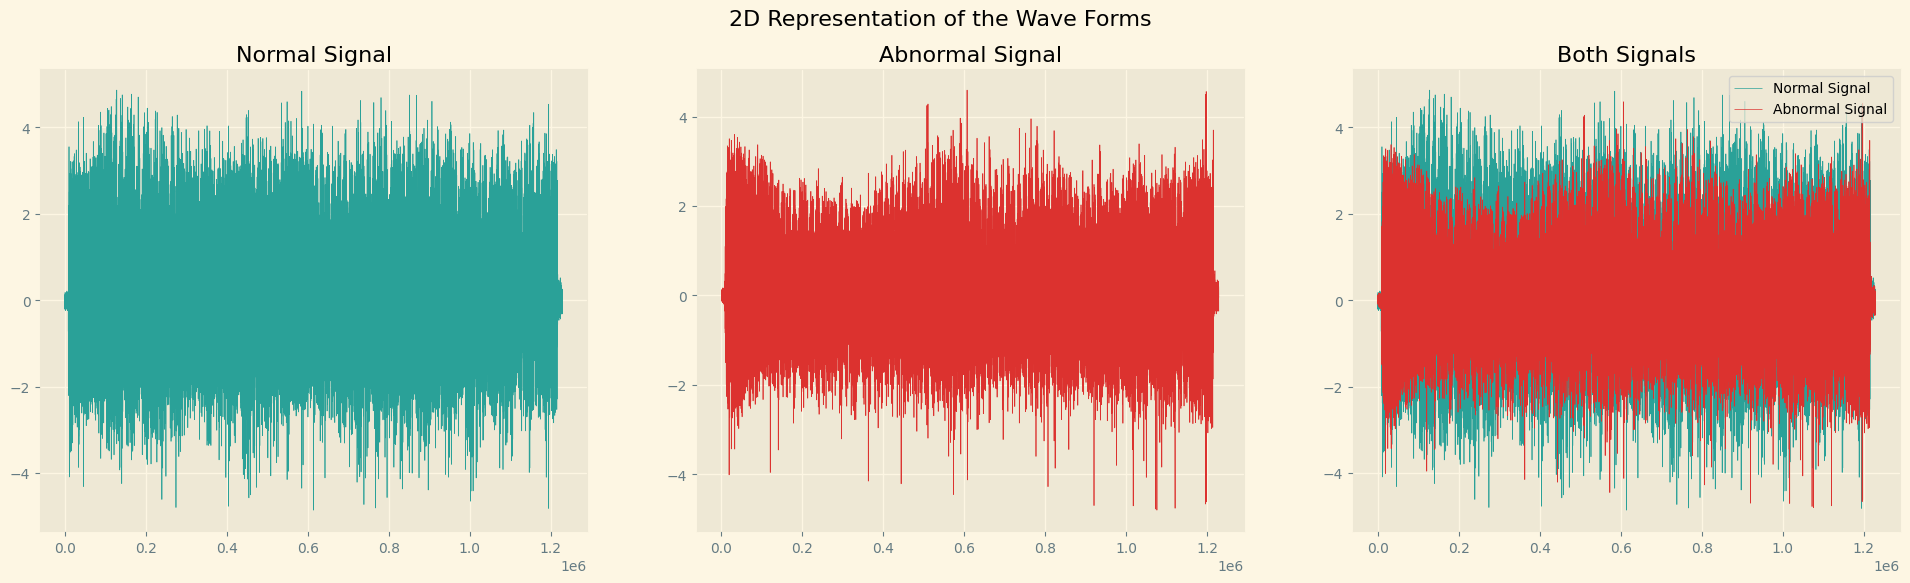

In [21]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
from scipy.fft import fft
from scipy.signal import get_window
from librosa.display import specshow
from scipy.signal import stft
import os
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
import librosa
import numpy as np
import matplotlib.pyplot as plt
from minisom import MiniSom
import pickle
import librosa
from sklearn.preprocessing import MinMaxScaler
import os
from bitstring import ConstBitStream
import librosa
import numpy as np
from sklearn.decomposition import KernelPCA
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.decomposition import IncrementalPCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import FeatureAgglomeration
from tensorflow.keras.models import load_model

def read_i32(filepath):
    with open(filepath, 'rb') as file:
        data = file.read()
        floararray = np.frombuffer(data, dtype=np.float32)
    return floararray

def normalize_audio(audio):
    return audio / np.max(np.abs(audio))

def load_sound_file(path):
    signal = read_i32(path)
    sr = 96000  # Update this with the actual sample rate of your audio files
    return signal, sr

def frame_audio_stft(audio, FFT_size=1024, hop_size=512, sample_rate=44100):
    # hop_size in ms
    
    audio = np.pad(audio, int(FFT_size / 2), mode='reflect')
    frame_len = np.round(sample_rate * hop_size / 1000).astype(int)
    frame_num = int((len(audio) - FFT_size) / frame_len) + 1
    frames = np.zeros((frame_num, FFT_size), dtype=np.float32)
    
    for n in range(frame_num):
        frames[n] = audio[n * frame_len:n * frame_len + FFT_size]
    
    _, _, Zxx = stft(frames, fs=sample_rate, nperseg=FFT_size)
    
    return frames, Zxx  # Return the framed audio and the STFT result

normal_file_path = "./Project_Files/Dataset/npore/Wall_17_AL_io_20220614/L01_09-56-46_io-pass/MikroGefell1_96khz_float32_09-56-46.I32"
abnormal_file_path = "./Project_Files/Dataset/pore/Wall_12_AL_Oel_20220615/L01_10-06-48_io-pass/MikroGefell1_96khz_float32_10-06-48.I32"

normal_signal, normal_sr = load_sound_file(normal_file_path)
abnormal_signal, abnormal_sr = load_sound_file(abnormal_file_path)

# Use the same parameters as in your original code
FFT_size = 1024
hop_size = 512
sample_rate = 96000

# Frame and calculate STFT for normal and abnormal signals
normal_frames, normal_stft = frame_audio_stft(normal_signal, FFT_size, hop_size, normal_sr)
abnormal_frames, abnormal_stft = frame_audio_stft(abnormal_signal, FFT_size, hop_size, abnormal_sr)

plt.style.use("Solarize_Light2")
prop_cycle = plt.rcParams["axes.prop_cycle"]
colors = prop_cycle.by_key()["color"]
# Plot the waveforms
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

# Normal Signal
axes[0].set_title("Normal Signal")
axes[0].plot(normal_signal, color=colors[1], linewidth=0.5)

# Abnormal Signal
axes[1].set_title("Abnormal Signal")
axes[1].plot(abnormal_signal, color=colors[5], linewidth=0.5)

# Both Signals
axes[2].set_title("Both Signals")
axes[2].plot(normal_signal, color=colors[1], linewidth=0.5, label="Normal Signal")
axes[2].plot(abnormal_signal, color=colors[5], linewidth=0.5, label="Abnormal Signal")

# Specify legend location
axes[2].legend(loc="upper right")

# Save the figure
fig.suptitle("2D Representation of the Wave Forms", fontsize=16)
plt.show()

##  Fourier Transforms in Acoustic Weld Inspection

Fourier transforms play a crucial role in the Acoustic Weld Inspection Project (AKoS) by providing a frequency-domain representation of acoustic signals. This section explores the theoretical foundation of Fourier transforms, their relevance in signal processing, and their specific application in the project.

####  Role in Feature Extraction

In the provided code for AKoS, Fourier transforms are employed to extract relevant features from acoustic signals. Specifically, the Short-Time Fourier Transform (STFT) is utilized to compute the mel spectrogram, a critical component in characterizing the frequency content of the acoustic data.

#### Short-Time Fourier Transform (STFT)

The STFT is a time-dependent extension of the Fourier transform, designed to capture variations in frequency content over short time intervals. It is defined as:

\[ X(t, f) = \int_{-\infty}^{\infty} x(\tau) \cdot w(\tau - t) \cdot e^{-j2\pi f \tau} \, d\tau \]

where:
- \( x(\tau) \) is the input signal,
- \( w(\tau - t) \) is a window function,
- \( X(t, f) \) is the resulting spectrogram.

In the AKoS project, the mel spectrogram is computed using the librosa library, providing a visual representation of the frequency content of the acoustic signals over time.


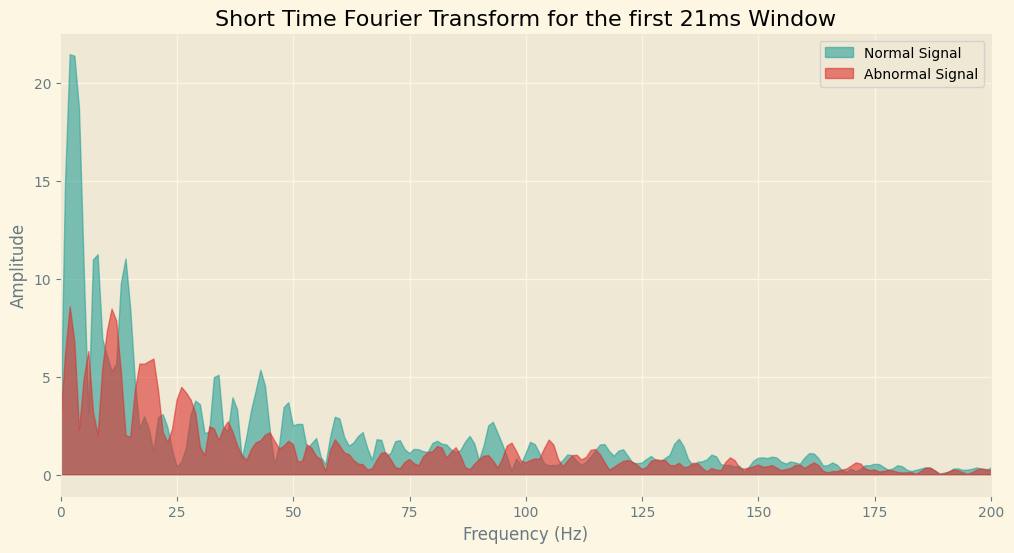

In [22]:
# Short-Time Fourier Transform
n_fft = 1024
hop_length = n_fft + 1
normal_stft = np.abs(librosa.stft(normal_signal[:n_fft], n_fft=n_fft, hop_length=hop_length))
abnormal_stft = np.abs(librosa.stft(abnormal_signal[:n_fft], n_fft=n_fft, hop_length=hop_length))

fig, ax = plt.subplots(figsize=(12, 6))

# Filled area plot for Normal Signal
ax.fill_between(np.arange(len(normal_stft)), 0, normal_stft.flatten(), color=colors[1], alpha=0.6, label="Normal Signal")

# Filled area plot for Abnormal Signal
ax.fill_between(np.arange(len(abnormal_stft)), 0, abnormal_stft.flatten(), color=colors[5], alpha=0.6, label="Abnormal Signal")

ax.set_title(f"Short Time Fourier Transform for the first {n_fft / normal_sr * 1000:.0f}ms Window")
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Amplitude")
ax.legend()
ax.set_xlim(0, 200)

plt.show()

#### Fourier Transforms in Feature Extraction

The following excerpt from the provided code illustrates the use of Fourier transforms in the feature extraction process:

```python
# Mel spectrogram
mel_spectrogram = librosa.feature.melspectrogram(
    y=signal,
    sr=sample_rate,
    n_fft=n_fft,
    hop_length=hop_length,
    n_mels=n_mels
)
log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
```

Here, the `librosa.feature.melspectrogram` function computes the mel spectrogram, and `librosa.power_to_db` converts it to a logarithmic scale for improved representation of perceptual loudness.


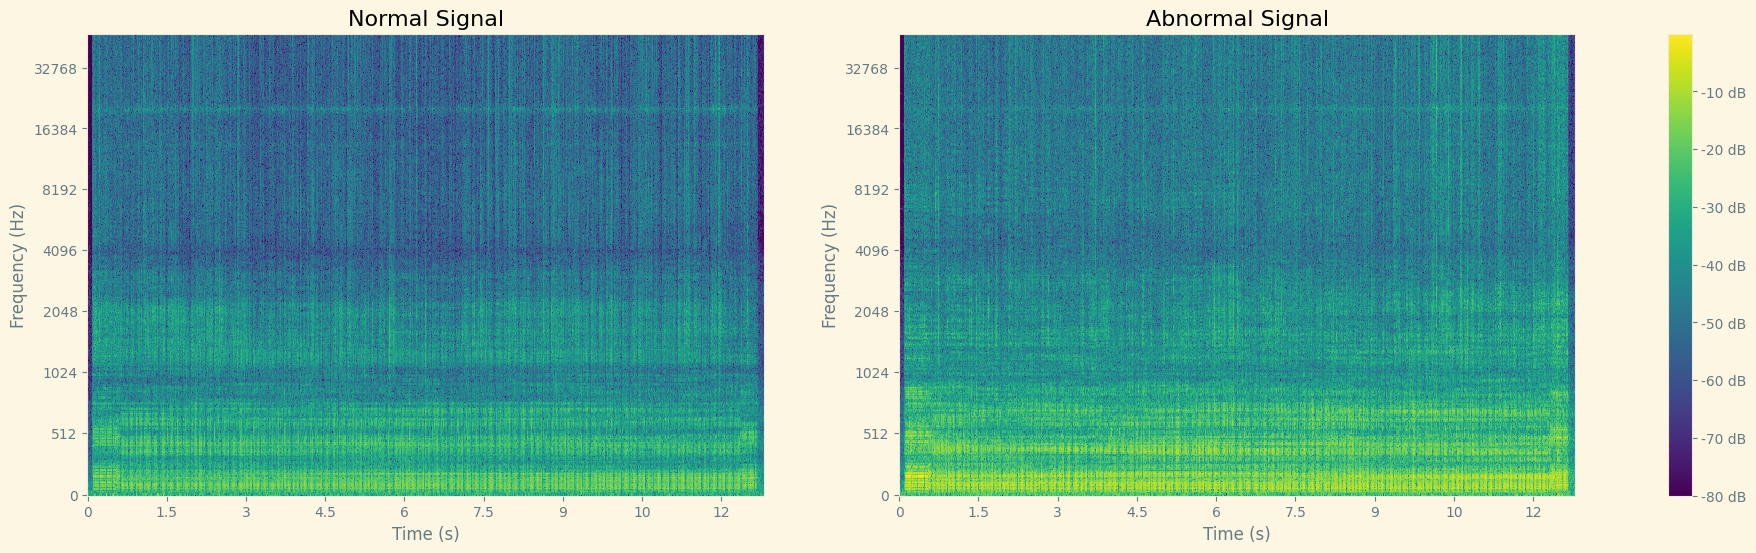

In [23]:
n_fft = 1024
hop_length = 512

# Calculate power spectrogram for normal signal
normal_stft = np.abs(librosa.stft(normal_signal, n_fft=n_fft, hop_length=hop_length))
normal_power_spectrogram = normal_stft ** 2  # Calculate power
normal_spectrogram = librosa.power_to_db(normal_power_spectrogram, ref=np.max)

# Calculate power spectrogram for abnormal signal
abnormal_stft = np.abs(librosa.stft(abnormal_signal, n_fft=n_fft, hop_length=hop_length))
abnormal_power_spectrogram = abnormal_stft ** 2  # Calculate power
abnormal_spectrogram = librosa.power_to_db(abnormal_power_spectrogram, ref=np.max)

# Plot Power Spectrograms
fig, axes = plt.subplots(1, 2, figsize=(24, 6))

# Normal Signal Power Spectrogram
axes[0].set_title("Normal Signal")
librosa.display.specshow(
    normal_spectrogram, sr=normal_sr, x_axis="time", y_axis="mel", cmap="viridis", ax=axes[0]
)
axes[0].set_xlabel("Time (s)")
axes[0].set_ylabel("Frequency (Hz)")

# Abnormal Signal Power Spectrogram
axes[1].set_title("Abnormal Signal")
librosa.display.specshow(
    abnormal_spectrogram, sr=abnormal_sr, x_axis="time", y_axis="mel", cmap="viridis", ax=axes[1]
)
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("Frequency (Hz)")

# Add colorbar
fig.colorbar(axes[0].collections[0], ax=axes, format="%+2.f dB")

plt.show()


# Mel Spectrogram


#### Role in Pore Amplitude Feature

Additionally, Fourier transforms contribute to the computation of the pore amplitude feature:

```python
# Pore amplitude feature
pore_amplitude = np.mean(np.abs(librosa.core.stft(signal, n_fft=n_fft, hop_length=hop_length)[pore_frequency_range[0]//10:pore_frequency_range[1]//10, :]), axis=0)
```

Here, the Short-Time Fourier Transform (STFT) is applied to extract the amplitude information within the specified frequency range associated with pores.

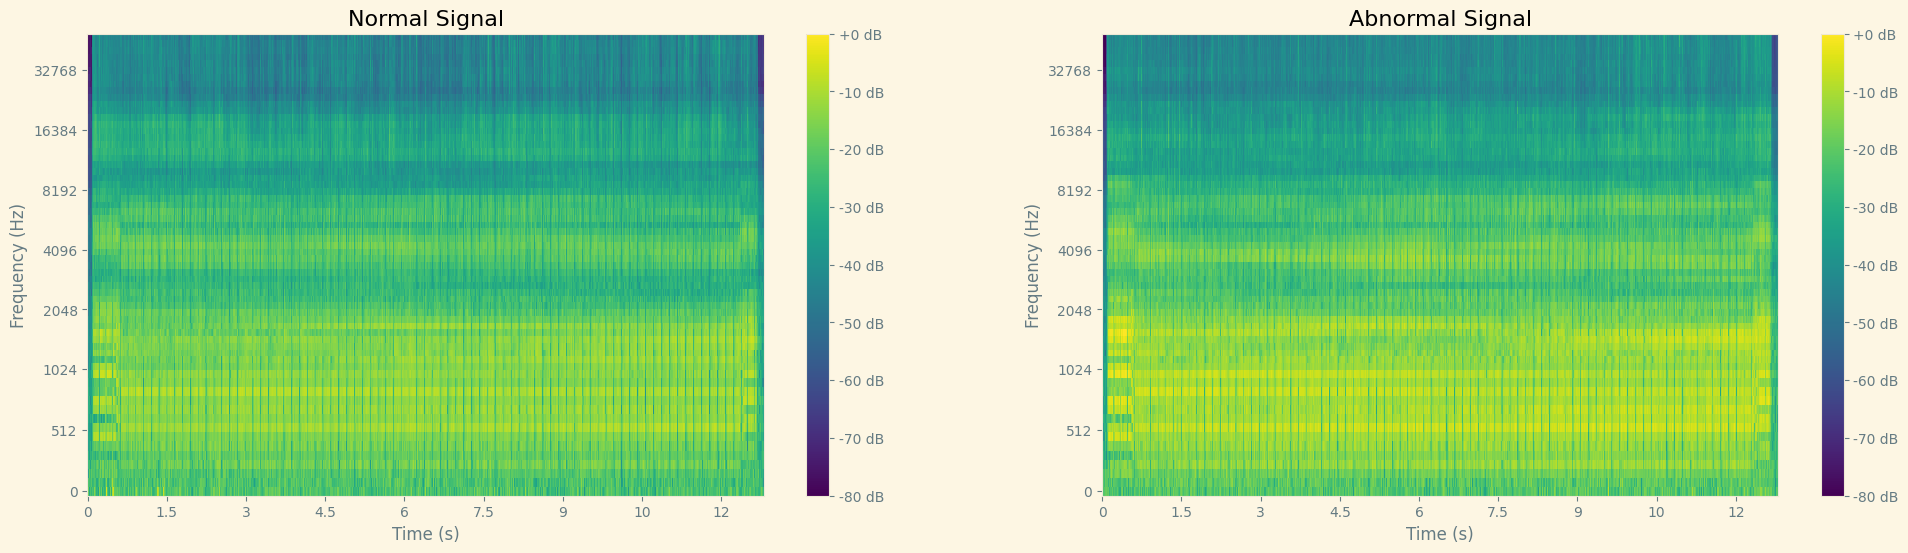

In [24]:

n_fft = 1024
hop_length = 512
n_mels = 64

# Compute mel-spectrogram for normal signal
S_normal = librosa.feature.melspectrogram(
    y=normal_signal, sr=normal_sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels
)
normal_mel_spectrogram = librosa.power_to_db(S_normal, ref=np.max)

# Compute mel-spectrogram for abnormal signal
S_abnormal = librosa.feature.melspectrogram(
    y=abnormal_signal, sr=abnormal_sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels
)
abnormal_mel_spectrogram = librosa.power_to_db(S_abnormal, ref=np.max)

# Plot Mel Spectrograms
fig, axes = plt.subplots(1, 2, figsize=(24, 6))

# Normal Signal Mel Spectrogram
axes[0].set_title("Normal Signal")
librosa.display.specshow(
    normal_mel_spectrogram,
    sr=normal_sr,
    hop_length=hop_length,
    x_axis="time",
    y_axis="mel",
    cmap="viridis",
    ax=axes[0]
)
axes[0].set_xlabel("Time (s)")
axes[0].set_ylabel("Frequency (Hz)")

# Check if there is data in the mel spectrogram before attempting to display the colorbar
if np.any(normal_mel_spectrogram):
    fig.colorbar(format="%+2.0f dB", mappable=axes[0].collections[0], ax=axes[0])

# Abnormal Signal Mel Spectrogram
axes[1].set_title("Abnormal Signal")
librosa.display.specshow(
    abnormal_mel_spectrogram,
    sr=abnormal_sr,
    hop_length=hop_length,
    x_axis="time",
    y_axis="mel",
    cmap="viridis",
    ax=axes[1]
)
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("Frequency (Hz)")

# Check if there is data in the mel spectrogram before attempting to display the colorbar
if np.any(abnormal_mel_spectrogram):
    fig.colorbar(format="%+2.0f dB", mappable=axes[1].collections[0], ax=axes[1])

plt.show()

#### Data Processing and Feature Extraction

This section outlines the data processing and feature extraction pipeline implemented in the Acoustic Weld Inspection Project (AKoS). The provided code encompasses various functions and libraries for reading, processing, and extracting features from raw acoustic data.
12.1 Reading Raw Acoustic Data

The read_i32 function serves as the initial step in the data processing pipeline. This function reads binary data from a specified file, assuming a 96 kHz sample rate, and converts it into a usable format. The resulting array, data_array, represents the raw acoustic signal.
12.2 Feature Extraction

The core of the feature extraction process lies in the feature_extraction function. This function utilizes several signal processing techniques to derive informative features from the acoustic signal. The features include:

    Mel Spectrogram: A frequency-domain representation of the signal's spectrum, emphasizing the distribution of energy across different frequency bands.

    Pore Amplitude Feature: Captures amplitude information within specified frequency ranges associated with pores or defects in weld seams.

    Spectral Contrast Feature: Measures the difference in amplitude between peaks and valleys in the spectrum, with statistical descriptors (mean and standard deviation) computed for added context.



In [ ]:
import os
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
import librosa
import numpy as np
import matplotlib.pyplot as plt
from minisom import MiniSom
import pickle
import librosa
from sklearn.preprocessing import MinMaxScaler
import os
from bitstring import ConstBitStream
import librosa
import numpy as np
from sklearn.decomposition import KernelPCA
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.decomposition import IncrementalPCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import FeatureAgglomeration
from tensorflow.keras.models import load_model



sample_rate=96000

def read_i32(filepath):
    with open(filepath, 'rb') as file:
        data = file.read()
        sample_rate = 96000
        float_array = np.frombuffer(data, dtype=np.float32)
    return np.array(float_array), sample_rate

def feature_extraction(signal, sr, n_fft=1024, hop_length=512, n_mels=64, frames=15, pore_frequency_range=(500, 2000), max_feature_length=3069):
    # Mel spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(
        y=signal,
        sr=sample_rate,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels
    )
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # Pore amplitude feature
    pore_amplitude = np.mean(np.abs(librosa.core.stft(signal, n_fft=n_fft, hop_length=hop_length)[pore_frequency_range[0]//10:pore_frequency_range[1]//10, :]), axis=0)

    # Spectral contrast feature
    spectral_contrast = librosa.feature.spectral_contrast(y=signal, sr=sample_rate, hop_length=hop_length)

    # Statistical descriptors for spectral contrast
    mean_spectral_contrast = np.mean(spectral_contrast, axis=0)
    std_spectral_contrast = np.std(spectral_contrast, axis=0)

    # Combine existing and additional features
    features_vector_size = log_mel_spectrogram.shape[1] - frames + 1
    dims = frames * n_mels + 3  # 1 for pore amplitude, 2 for mean and std of spectral contrast

    if features_vector_size < 1:
        return np.empty((0, dims), np.float32)

    features = np.zeros((features_vector_size, dims), np.float32)

    for t in range(frames):
        features[:, n_mels * t: n_mels * (t + 1)] = log_mel_spectrogram[:, t:t + features_vector_size].T

    # Insert the pore amplitude feature
    features[:, -3] = pore_amplitude[:features_vector_size]

    # Insert mean and std of spectral contrast
    features[:, -2] = mean_spectral_contrast[:features_vector_size]
    features[:, -1] = std_spectral_contrast[:features_vector_size]

    # Zero-pad or truncate the feature vectors to a consistent length
    if features.shape[0] < max_feature_length:
        padded_features = np.zeros((max_feature_length, dims), dtype=features.dtype)
        padded_features[:features_vector_size, :] = features
        features = padded_features
    elif features.shape[0] > max_feature_length:
        features = features[:max_feature_length, :]

    return features

# Function to process files and extract features
def process_files(directory):
    feature_dataset = []

    for root, dirs, files in os.walk(directory):
        for file in files:
            if "MikroGefell1_96khz" in file:
                file_path = os.path.join(root, file)
                data_array, sr = read_i32(file_path)
                # Extract features using the provided function
                features= feature_extraction(data_array, sample_rate)
                feature_dataset.append(features)

    # Convert the list of arrays into a 2D array
    feature_dataset = np.vstack(feature_dataset)

    return feature_dataset


In [ ]:

normal_directory_path = "./Project_Files/Dataset/npore/"
abnormal_directory_path = "./Project_Files/Dataset/pore/"

# Process files to get feature dataset
train_data= process_files(normal_directory_path)
test_data= process_files(abnormal_directory_path)


In [12]:
print(train_data.shape)


(153450, 963)


In [7]:

train_pickle = "./Project_Files/Dataset/train_no_pore_96khz.pkl"
test_pickle = "./Project_Files/Dataset/test_pore_96khz.pkl"

with open(train_pickle, 'rb') as file:
    train_data = pickle.load(file)

with open(test_pickle, 'rb') as file:
    test_data = pickle.load(file)

##  Feature Visualization

This section demonstrates the visualization of key features extracted from acoustic signals in the Acoustic Weld Inspection Project (AKoS). The code provided utilizes matplotlib and librosa libraries to create visual representations of Mel spectrograms, Pore Amplitude Features, and Spectral Contrast Features for both training and test signals.

###  Mel Spectrograms

The Mel spectrogram is a crucial feature that provides a frequency-domain representation of the signal's spectrum. It emphasizes the distribution of energy across different frequency bands, offering insights into the acoustic characteristics of weld seams.

```python
# Plot Mel spectrogram for the training signal
mel_spectrogram_train = librosa.feature.melspectrogram(y=train_signal, sr=sample_rate, n_mels=n_mels)
log_mel_spectrogram_train = librosa.power_to_db(mel_spectrogram_train, ref=np.max)
librosa.display.specshow(log_mel_spectrogram_train, cmap='viridis', x_axis='time', y_axis='mel', ax=axes[0, 0])
axes[0, 0].set_title("Train Signal Mel Spectrogram")

# Plot Mel spectrogram for the test signal
mel_spectrogram_test = librosa.feature.melspectrogram(y=test_signal, sr=sample_rate, n_mels=n_mels)
log_mel_spectrogram_test = librosa.power_to_db(mel_spectrogram_test, ref=np.max)
librosa.display.specshow(log_mel_spectrogram_test, cmap='viridis', x_axis='time', y_axis='mel', ax=axes[0, 1])
axes[0, 1].set_title("Test Signal Mel Spectrogram")
```

These visualizations offer a qualitative understanding of the frequency content of both training and test signals.

###  Pore Amplitude Features

The Pore Amplitude Feature captures amplitude information within specified frequency ranges associated with pores or defects in weld seams. This feature is visualized for both training and test signals.

```python
# Plot Pore Amplitude Feature for the training signal
axes[0, 2].plot(train_data[10, -3], label="Train Signal")
axes[0, 2].set_title("Train Signal Pore Amplitude Feature")
axes[0, 2].legend()

# Plot Pore Amplitude Feature for the test signal
axes[1, 2].plot(test_data[10, -3], label="Test Signal")
axes[1, 2].set_title("Test Signal Pore Amplitude Feature")
axes[1, 2].legend()
```

These plots visualize the amplitude variations within the specified frequency ranges, aiding in the identification of anomalies or defects.

###  Spectral Contrast Features

Spectral Contrast Features measure the difference in amplitude between peaks and valleys in the spectrum. The code visualizes these features for both training and test signals.

```python
# Plot Spectral Contrast Features for the training signal
axes[1, 0].imshow(train_data[0, :-3].reshape(frames, n_mels).T, aspect='auto', cmap='viridis', extent=[0, frames, 0, n_mels])
axes[1, 0].set_title("Train Signal Spectral Contrast Features")

# Plot Spectral Contrast Features for the test signal
axes[1, 1].imshow(test_data[0, :-3].reshape(frames, n_mels).T, aspect='auto', cmap='viridis', extent=[0, frames, 0, n_mels])
axes[1, 1].set_title("Test Signal Spectral Contrast Features")
```

These visualizations provide insights into the amplitude variations across different frequency bands, aiding in the detection of distinctive patterns associated with anomalies.

This feature visualization section enhances the interpretability of the extracted features and provides a qualitative assessment of the acoustic characteristics associated with weld seams.

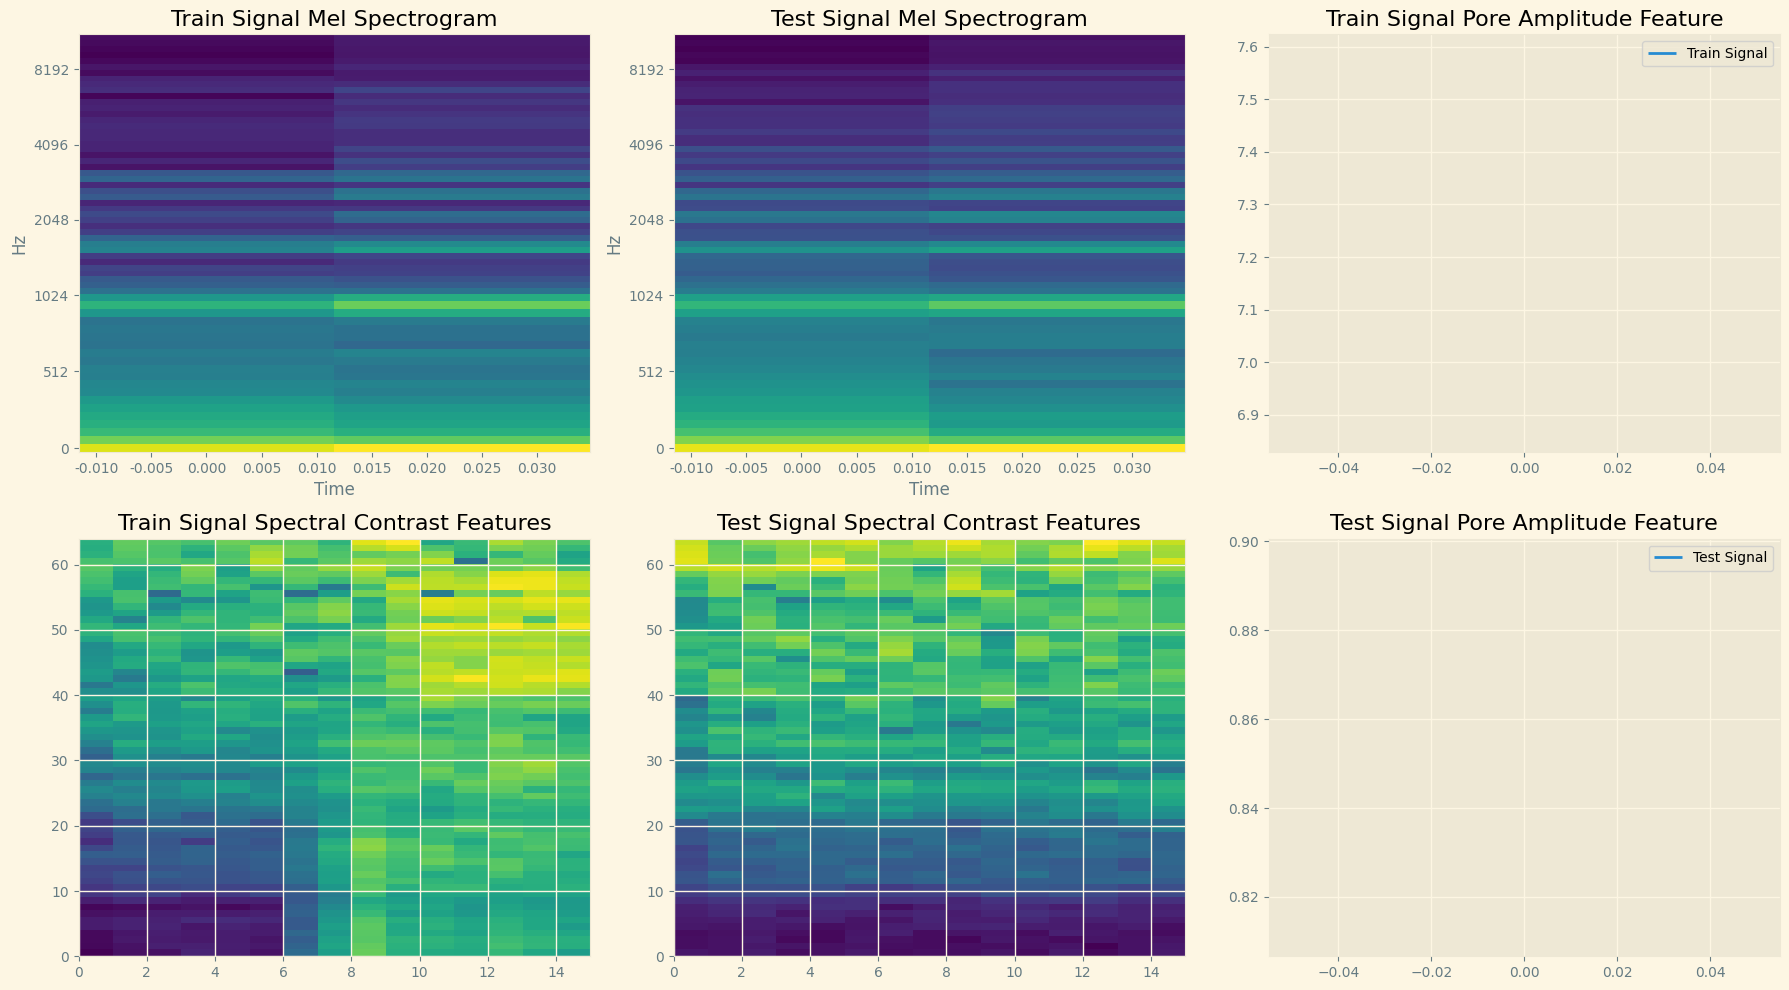

In [ ]:
import matplotlib.pyplot as plt
import librosa.display

# Assume you have the function feature_extraction defined and train_data, test_data are available

# Example signals (replace with your actual signals)
train_signal = train_data[10, :-3]  # Exclude the last three features (pore amplitude, mean, and std of spectral contrast)
test_signal = test_data[10, :-3]  # Exclude the last three features (pore amplitude, mean, and std of spectral contrast)

# Parameters for feature extraction (replace with your actual parameters)
sample_rate = 96000
n_mels = 64
frames = 15
pore_frequency_range = (500, 2000)

# Plot the features
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Plot Mel spectrogram for the training signal
mel_spectrogram_train = librosa.feature.melspectrogram(y=train_signal, sr=sample_rate, n_mels=n_mels)
log_mel_spectrogram_train = librosa.power_to_db(mel_spectrogram_train, ref=np.max)
librosa.display.specshow(log_mel_spectrogram_train, cmap='viridis', x_axis='time', y_axis='mel', ax=axes[0, 0])
axes[0, 0].set_title("Train Signal Mel Spectrogram")

# Plot Mel spectrogram for the test signal
mel_spectrogram_test = librosa.feature.melspectrogram(y=test_signal, sr=sample_rate, n_mels=n_mels)
log_mel_spectrogram_test = librosa.power_to_db(mel_spectrogram_test, ref=np.max)
librosa.display.specshow(log_mel_spectrogram_test, cmap='viridis', x_axis='time', y_axis='mel', ax=axes[0, 1])
axes[0, 1].set_title("Test Signal Mel Spectrogram")

# Plot Pore Amplitude Feature for the training signal
axes[0, 2].plot(train_data[10, -3], label="Train Signal")
axes[0, 2].set_title("Train Signal Pore Amplitude Feature")
axes[0, 2].legend()

# Plot Pore Amplitude Feature for the test signal
axes[1, 2].plot(test_data[10, -3], label="Test Signal")
axes[1, 2].set_title("Test Signal Pore Amplitude Feature")
axes[1, 2].legend()

# Plot Spectral Contrast Features for the training signal
axes[1, 0].imshow(train_data[0, :-3].reshape(frames, n_mels).T, aspect='auto', cmap='viridis', extent=[0, frames, 0, n_mels])
axes[1, 0].set_title("Train Signal Spectral Contrast Features")

# Plot Spectral Contrast Features for the test signal
axes[1, 1].imshow(test_data[0, :-3].reshape(frames, n_mels).T, aspect='auto', cmap='viridis', extent=[0, frames, 0, n_mels])
axes[1, 1].set_title("Test Signal Spectral Contrast Features")

# Adjust layout
plt.tight_layout()
plt.show()


## 5. Pore Amplitude Feature and Signal Visualization

The Pore Amplitude Feature is a critical aspect of the Acoustic Weld Inspection Project (AKoS), providing insights into characteristics associated with pores or defects in weld seams. This section discusses the theoretical foundation of the Pore Amplitude Feature and includes visualizations of the feature for both training and test signals.

### 5.1 Theoretical Overview of Pore Amplitude Feature

The Pore Amplitude Feature is computed through the Short-Time Fourier Transform (STFT), a technique that reveals the amplitude information within specified frequency ranges associated with pores or defects in weld seams. In the context of AKoS, the Pore Amplitude Feature becomes a valuable descriptor for identifying anomalies in acoustic signals.


/home/shaxpy/.local/lib/python3.8/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=963
  warnings.warn(


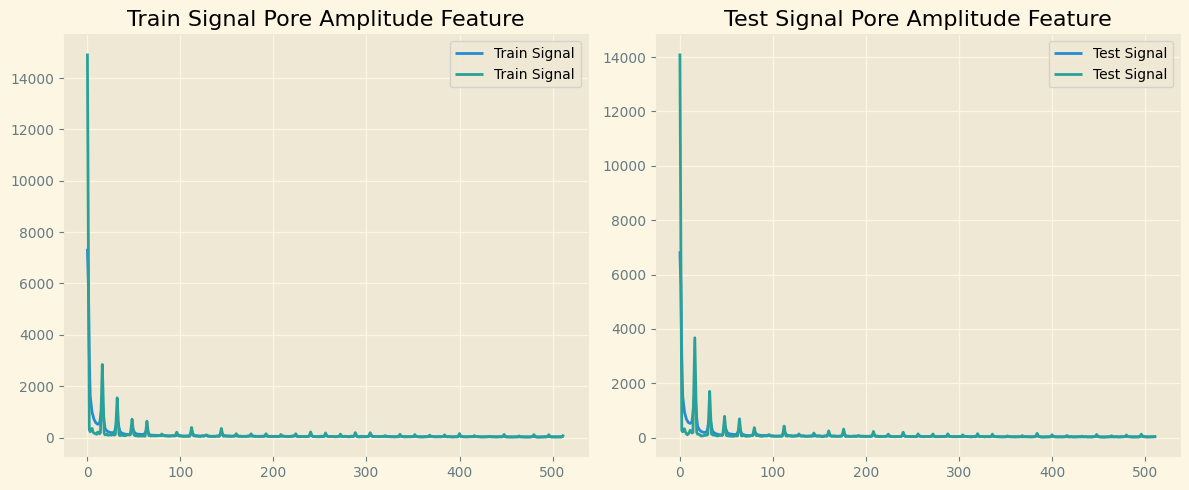

In [18]:
import matplotlib.pyplot as plt
import librosa.display

# Function to calculate Pore Amplitude Feature
def pore_amplitude_feature(signal, pore_frequency_range=(500, 2000), sample_rate=96000, n_fft=1024, hop_length=512):
    stft_result = librosa.core.stft(signal, n_fft=n_fft, hop_length=hop_length)
    pore_amplitude = np.mean(np.abs(stft_result[pore_frequency_range[0]//10:pore_frequency_range[1]//10, :]), axis=0)
    return pore_amplitude

# Example signals (replace with your actual signals)
train_signal = train_data  # Exclude the last three features (pore amplitude, mean, and std of spectral contrast)
test_signal = test_data  # Exclude the last three features (pore amplitude, mean, and std of spectral contrast)

# Calculate Pore Amplitude Feature for the training signal
pore_amplitude_train = pore_amplitude_feature(train_signal)
# Calculate Pore Amplitude Feature for the test signal
pore_amplitude_test = pore_amplitude_feature(test_signal)

# Plot the features
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot Pore Amplitude Feature for the training signal
axes[0].plot(pore_amplitude_train, label="Train Signal")
axes[0].set_title("Train Signal Pore Amplitude Feature")
axes[0].legend()

# Plot Pore Amplitude Feature for the test signal
axes[1].plot(pore_amplitude_test, label="Test Signal")
axes[1].set_title("Test Signal Pore Amplitude Feature")
axes[1].legend()

# Adjust layout
plt.tight_layout()
plt.show()
